<img src="img/map_function.png" width="200" align="right">
Python provides a few higher order (or functional programming) functions in the standard library that can be quite useful:

* map
* filter
* reduce
* lambda
* list comprehensions

<div align="right"><i>Picture from <a href="https://swiftunboxed.com/open-source/map">SwiftUnboxed</a></i></div>

This article series focuses on exploring these. In this notebook, we'll learn more about the `map` Python function. I will assume you already know about list expressions, but might not be so familiar with the other four.

At first glance `map` seems a bit redundant &mdash; all it does is apply a function to every member in an iterable (list, dict, tuple, set, etc.)? Playing with it though, we'll see that it can be used to tidy up your code, make it more readable, and even give performance gains when used with very large iterables due to its lazy evaluation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
from itertools import repeat
from time import time

Let's create a simple function, which we'll use in these examples. `map` takes in a function and an iterable, and applies the first to the second. It returns a map iterator, that applies the function in turn for every item it contains. This language choice was made in order to save memory, and make loops slightly faster to process.

In [2]:
def square(n):
    return n * n


print(square(121))

14641


In [3]:
data = [121, 122, 123, 124, 129]

If you try, you get an error if you try to apply the function to the list.

In [4]:
try:
    square(data)
except TypeError as e:
    print(TypeError, e)

<class 'TypeError'> can't multiply sequence by non-int of type 'list'


Rather, you need to apply it to every member. Using a "traditional" for-loop, this is how you'd do it:

In [5]:
square_data = []
for i in data:
    square_data.append(square(i))
square_data

[14641, 14884, 15129, 15376, 16641]

In [6]:
# Of course, the same can be done with list comprehensions
[square(i) for i in data]

[14641, 14884, 15129, 15376, 16641]

Let's try the same thing using `map`. Calling it directly (`map(func, iterable)`), it only defines the new iterable it creates, like a generator.

In [7]:
map(square, data)

To get the values, you need to cast it to a list.

In [8]:
list(map(square, data))

[14641, 14884, 15129, 15376, 16641]

Using `map` has clear-cut advantages in readability when you already know you'll need to apply a function to the iterable you'll be looping over. Compare:

In [9]:
for i in data:
    n = square(i)
    if n > 15000:
        # Do stuff
        print(i)

15129
15376
16641


To `map`:

In [10]:
for n in map(square, data):
    if n > 15000:
        # Do stuff
        print(i)

15129
15376
16641


Or even more tersely, with a list comprehension. To me, this is clear and concise code, that does not need any comments, and is easy to maintain.

In [11]:
print([n for n in map(square, data) if n > 15000])

[15129, 15376, 16641]


## Benchmarks
### Is `map` faster than a list comprehension?
As `map` is used to apply a function to every member in an iterable, there are a lot of similarities with Python list comprehensions, which can easily do the same. For example, here is a simple list comprehension:

    x = [square(n) for n in range(100)]
    
Which would return a list of the square of all numbers from 0 to 99.

But is one method faster than the other? Let's map a simple function over a very large array and get its sum.

In [12]:
def time_map(n):
    t0 = time()
    sum(map(square, range(n)))
    return time() - t0


def time_list_comp(n):
    t0 = time()
    # This is actually called a generator expression
    # It does not generate the list items ahead of time
    # Rather, items are calculated lazily, like `map`
    sum(square(i) for i in range(n))
    return time() - t0


test_range = [2**x for x in range(10, 27)]
times_map = [time_map(n) for n in test_range]
times_list_comp = [time_list_comp(n) for n in test_range]

df_map = pd.DataFrame([times_map, times_list_comp]).T
df_map.columns = ['map', 'list_comp']
df_map.index = test_range
df_map

,map,list_comp
1024,0.000000,0.000000
2048,0.000000,0.000000
4096,0.000000,0.000000
8192,0.000000,0.000000
16384,0.000000,0.000000
32768,0.010000,0.010000
65536,0.010000,0.010000
131072,0.020000,0.020000
262144,0.059999,0.049999
524288,0.089999,0.099999


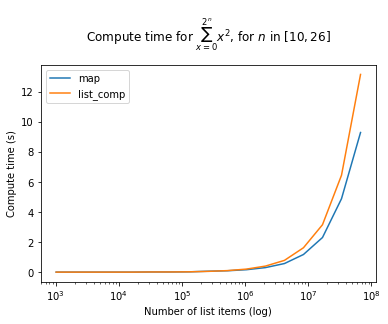

In [13]:
df_map.plot(logx=True)
plt.title('Compute time for $\sum_{x=0}^{2^{n}} x^{2}$, for $n$ in $[10, 26]$\n')
plt.xlabel('Number of list items (log)')
plt.ylabel('Compute time (s)')
plt.show()

So clearly `map` is faster than a list comprehension, as much as 36% faster for our last head-to-head, with an iterable with over 67M records. Note that I've started with a range of 1024 items, anything smaller and the performance was basically identical.

>**Heuristic**

Based on this crude benchmark, using `map` instead of list comprehensions can make a difference **when iterables have around or above a million items**.

### `n * n` vs `n ** 2` vs `np.square`
I see variations on this all the time in all-Python projects, and even though unrolling all expressions of $x^{2}$ as `n * n` might be harder to read in equation-heavy code, performance also matters, and it is probably best to standardize your codebase on one or the other.

So, what's faster, `n * n` or `n ** 2`... or are they equivalent? And how do they compare to numpy?

In [14]:
def square(n):
    return n * n


def exp_2(n):
    return n ** 2

In [15]:
test = range(3, 1024**2)
print(sum(map(square, test)))

384306618446643195


In [16]:
%%timeit
sum(map(square, test))

148 ms ± 8.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
sum(map(exp_2, test))

471 ms ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So almost 3 times faster.

#### Numpy
That certainly settles it then... How does it compare to numpy?

In [18]:
test_np = np.arange(3, 1024**2)

In [19]:
np.sum(np.square(test_np))

1431830523

>**Aside**

Well... I mean it was fast, but it's wrong! What's the matter here?

In [20]:
test_np

array([      3,       4,       5, ..., 1048573, 1048574, 1048575])

In [21]:
np.square(test_np)

array([       9,       16,       25, ..., -6291447, -4194300, -2097151], dtype=int32)

There it is, we're using the [wrong data type](https://docs.scipy.org/doc/numpy/user/basics.types.html). Numpy needed to allocate a `dtype=uint32` or `dtype=int64` and didn't. Instead, it's interpreting the squared numbers as negative because of the large number limit.

>**End Aside**

So we'll need to get the dtype specific either with `np.square` or `np.arange`:

In [22]:
%%timeit
# Can't cast np.square to `uint32` for some reason, but `int64` works fine
np.sum(np.square(test_np, dtype='int64'))

6.14 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit
# Or we can specify `uint32` directly from np.arange
np.sum(np.square(np.arange(3, 1024**2, dtype='uint32')))

6.83 ms ± 550 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Which ends up being a whole **26 times faster** than the standard Python interpreter (cPython). 

### Benchmarks for exponentials
That's fine for $n^{2}$, but what about other exponentials, say cubes? In other words, for integer-valued exponents from 1 to 15, how do these look when graphed?

In [24]:
def exponent_1(n, k):
    """Returns n (* n)... k-1 times"""
    # This is pretty ugly but I don't know how to code it
    # without eval(), which is super slow.
    if k == 1:
        return n
    if k == 2:
        return n * n
    if k == 3:
        return n * n * n
    if k == 4:
        return n * n * n * n
    if k == 5:
        return n * n * n * n * n
    if k == 6:
        return n * n * n * n * n * n
    if k == 7:
        return n * n * n * n * n * n * n
    if k == 8:
        return n * n * n * n * n * n * n * n
    if k == 9:
        return n * n * n * n * n * n * n * n * n
    if k == 10:
        return n * n * n * n * n * n * n * n * n * n
    if k == 11:
        return n * n * n * n * n * n * n * n * n * n * n
    if k == 12:
        return n * n * n * n * n * n * n * n * n * n * n * n
    if k == 13:
        return n * n * n * n * n * n * n * n * n * n * n * n * n
    if k == 14:
        return n * n * n * n * n * n * n * n * n * n * n * n * n * n
    if k == 15:
        return n * n * n * n * n * n * n * n * n * n * n * n * n * n * n
    raise ValueError


def exponent_2(n, k):
    return n ** k

For `map` calls with multiple arguments, the docs explicitly suggest this is the main use for `itertools.repeat`([See Stack Overflow post](https://stackoverflow.com/a/27025330/5531059)):

>Make an iterator that returns object over and over again. Runs indefinitely unless the times argument is specified. Used as argument to `map()` for invariant parameters to the called function. Also used with `zip()` to create an invariant part of a tuple record.

In [25]:
def time_exponent_1(k):
    t0 = time()
    sum(map(exponent_1, test, repeat(k)))
    return time() - t0


def time_exponent_2(k):
    t0 = time()
    sum(map(exponent_2, test, repeat(k)))
    return time() - t0


test = range(3, 1024**2)
times_1 = [time_exponent_1(k) for k in range(1, 16)]
times_2 = [time_exponent_2(k) for k in range(1, 16)]

In [26]:
df = pd.DataFrame([times_1, times_2]).T
df.columns = ['n * n * ...', 'n ** k']
df.index = range(1, 16)
df.head()

,n * n * ...,n ** k
1,0.179998,0.509995
2,0.229998,0.499995
3,0.359996,0.509995
4,0.389996,0.589994
5,0.429996,0.559994


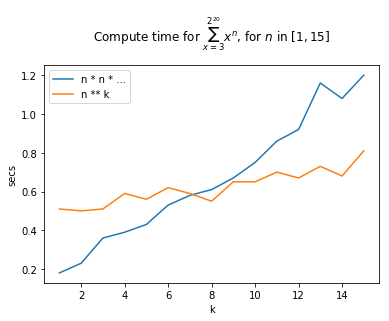

In [27]:
df.plot()
plt.title('Compute time for $\sum_{x=3}^{2^{20}} x^{n}$, for $n$ in $[1, 15]$\n')
plt.xlabel('k')
plt.ylabel('secs')
plt.show()

So with this naive benchmark in place, it would seem as though `n * n * ...` is faster than `n ** k` for $k \leq 7$, but that margin is slim for 5 to 7. In practice, one should probably only use `n * n * n * n * n * n * n` in extraordinary circumstances. Readability counts!

>**Heuristic**

Use `n * n * ...` for $n$ in $[2, 4]$.

## Conclusions
Using `map` has clear advantages over other Python methods of applying functions to iterables, and can make your code more elegant and faster.

When tuning for performance,

1. Switch to `map` instead of list comprehensions for iterables with around a million items or more.
2. Unless you really can't use numpy, use `n * n * ...` instead of `n**k`, for `k` in `[2, 4]`

## Keep on reading!
Next in the *Higher-level functions in Python* series we'll take a look at [the `reduce` function](higher-level-functions-python-reduce.html).